In [49]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
# !unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/ISIC_0029342.jpg  
  inflating: h

load data

In [35]:
# path='hmnist_28_28_RGB.csv'
# path= r'hmnist_28_28_RGB/hmnist_28_28_RGB.csv'
path = "/content/hmnist_28_28_RGB.csv"
df=pd.read_csv(path)
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2353 entries, pixel0000 to label
dtypes: int64(2353)
memory usage: 179.8 MB


Shuffle the dataset to avoiding bias that if data is ordered in some way the model may end up learning pattern of order rather than actual data

In [37]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,71,41,65,146,109,132,182,147,166,190,...,188,151,177,130,93,115,59,34,57,1
1,192,170,216,198,179,223,202,177,220,203,...,175,138,176,149,95,125,162,123,155,4
2,189,176,202,188,173,197,187,169,190,188,...,191,169,195,190,168,194,189,165,190,4
3,14,12,8,11,7,5,17,13,12,70,...,176,161,159,148,135,133,82,71,68,4
4,164,154,164,164,154,164,166,157,166,171,...,174,168,180,173,167,181,172,167,179,4


Split the dataset into X and Y

In [39]:
X = df.drop(['label'], axis=1).values
y = df['label'].values

Reshape the data to 28x28x3 and resize to 32x32x3

VGG16 need shape of data is 32x32x3

In [41]:
X = X.reshape(-1, 28, 28, 3)
X_resized = np.array([tf.image.resize(image, [32, 32]) for image in X])

Normalize the pixel values

In [42]:
X_resized = X_resized / 255.0

Convert labels to categorical format

In [43]:
df.label.unique()

array([1, 4, 2, 6, 0, 5, 3])

In [44]:
y_categorical = to_categorical(y, num_classes=7)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X_resized, y_categorical, test_size=0.2, random_state=42)
print(f"Shape X_train: {x_train.shape} and y_train: {y_train.shape}")
print(f"Shape X_test: {x_test.shape} and y_test: {y_test.shape}")

Shape X_train: (8012, 32, 32, 3) and y_train: (8012, 7)
Shape X_test: (2003, 32, 32, 3) and y_test: (2003, 7)


Visualize some images from the training set

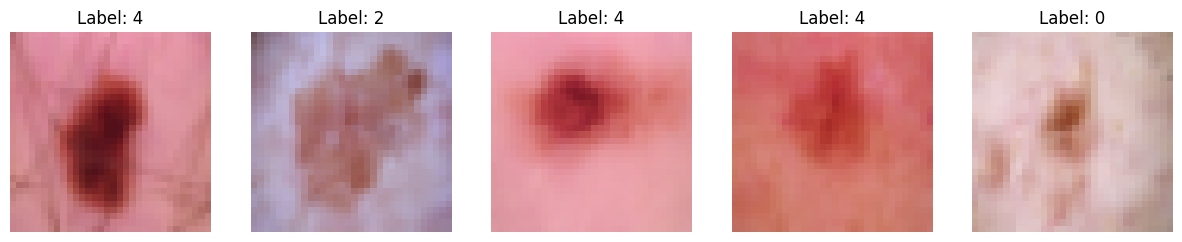

In [46]:
num_images = 5
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axes[i].imshow(x_train[i])
    axes[i].set_title(f"Label: {np.argmax(y_train[i])}")
    axes[i].axis('off')
plt.show()

Data augmentation

In [47]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Build Model

In [48]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential()
for layer in base_model.layers:
    model.add(layer)

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

# Model Training

In [50]:
callback_checkpoint = ModelCheckpoint(filepath='vgg_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callback_lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=0.00001)

history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                    validation_data=(x_test, y_test),
                    epochs=100,
                    callbacks=[callback_early_stopping, callback_checkpoint, callback_lr_reduction])

history.history

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 2.1398 - accuracy: 0.6654
Epoch 1: val_accuracy improved from -inf to 0.65901, saving model to vgg_model.h5
63/63 [==============================] - 11s 106ms/step - loss: 2.1398 - accuracy: 0.6654 - val_loss: 1.3151 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 1.2009 - accuracy: 0.6692
Epoch 2: val_accuracy improved from 0.65901 to 0.68347, saving model to vgg_model.h5
63/63 [==============================] - 7s 107ms/step - loss: 1.2009 - accuracy: 0.6692 - val_loss: 1.0829 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 1.0763 - accuracy: 0.6745
Epoch 3: val_accuracy improved from 0.68347 to 0.68597, saving model to vgg_model.h5
63/63 [==============================] - 7s 117ms/step - loss: 1.0763 - accuracy: 0.6745 - val_loss: 1.0250 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 4/100
63/63 [===========

{'loss': [2.1397857666015625,
  1.2008907794952393,
  1.0762815475463867,
  1.026379108428955,
  1.0186773538589478,
  1.0135926008224487,
  0.9776471257209778,
  0.9672630429267883,
  0.9405738711357117,
  0.963283896446228,
  0.9334327578544617,
  0.9125807881355286,
  0.908408522605896,
  0.9019066095352173,
  0.8831197023391724,
  0.8901387453079224,
  0.9028322696685791,
  0.884037971496582,
  0.8713182806968689,
  0.85976243019104,
  0.8445227146148682,
  0.8478243947029114,
  0.8226710557937622,
  0.8147870302200317,
  0.8241671323776245,
  0.8005378842353821,
  0.7941457629203796,
  0.7836729288101196,
  0.7661635875701904,
  0.7820592522621155,
  0.7657384872436523,
  0.7705568671226501,
  0.7551321387290955,
  0.7439329028129578,
  0.7374272346496582,
  0.720998227596283,
  0.7264163494110107,
  0.7180376648902893,
  0.7053960561752319,
  0.7075902819633484,
  0.7092815041542053,
  0.7104308605194092,
  0.6739998459815979,
  0.6600132584571838,
  0.6456764340400696,
  0.63343

Model Evaluation

In [51]:
model.load_weights('vgg_model.h5')
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Loss: {loss}, Accuracy: {acc}")

63/63 - 1s - loss: 0.6465 - accuracy: 0.7843 - 568ms/epoch - 9ms/step
Loss: 0.6464815139770508, Accuracy: 0.784323513507843


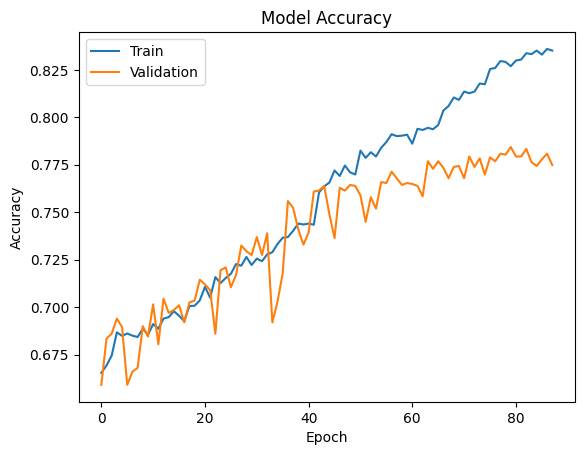

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

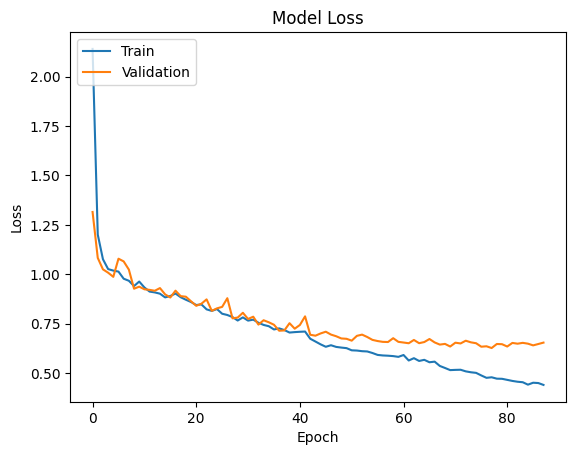

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
cm

63/63 [==============================] - 1s 8ms/step


array([[  34,    7,   20,    0,    4,    0,    5],
       [  17,   64,    8,    0,   16,    0,    2],
       [  22,   11,  128,    0,   49,    0,   23],
       [   2,    8,    2,    0,    5,    0,    2],
       [   1,    9,   37,    0, 1231,    1,   41],
       [   0,    3,    0,    0,    8,   18,    1],
       [   8,    3,   33,    0,   80,    4,   96]])

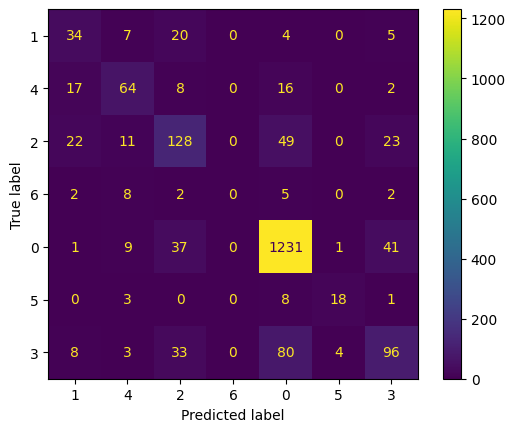

In [55]:
cmd = ConfusionMatrixDisplay(cm, display_labels=df.label.unique())
cmd.plot()

In [56]:
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_training_accuracy * 100:.2f}%")
print(f"Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%")

Final Training Accuracy: 83.51%
Final Validation Accuracy: 77.48%


Finally save model

In [57]:
model.save('best_model.h5')

Model Testing

Finally you can replace numbers of output with names

In [ ]:
# # reference: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000/discussion/183083
# classes={
#     0:('akiec', 'actinic keratoses and intraepithelial carcinomae'),

#     1:('bcc' , 'basal cell carcinoma'),

#     2:('bkl', 'benign keratosis-like lesions'),

#     3:('df', 'dermatofibroma'),

#     4:('nv', ' melanocytic nevi'),

#     5:('vasc', ' pyogenic granulomas and hemorrhage'),

#     6:('mel', 'melanoma'),
# }